In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import data_processing
import math
import ipympl
from scipy import stats
from numpy import NaN
from matplotlib.pyplot import box
from sklearn.linear_model import LinearRegression


In [2]:
NUM_SAMPLES_BUFFER = 600
FILTER_AFTER_N = 200
BP_LOW_CUTOFF = 20
BP_HIGH_CUTOFF = 500
ORDER = 2
LP_HIGH_CUTOFF = 5

Mvc = 379.6267184490227
percent_mvc = 0.3
mvc_threshold = percent_mvc*Mvc

In [3]:
%matplotlib widget

In [4]:
data1_haptics = np.loadtxt("Dailyn/with_feedback/raw_data_20220805-142247")
data2_haptics = np.loadtxt("Dailyn/with_feedback/raw_data_20220805-143530")
data3_haptics = np.loadtxt("Dailyn/with_feedback/raw_data_20220805-143804")

data_timestamps1_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_data_20220805-142247")
data_timestamps2_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_data_20220805-143530")
data_timestamps3_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_data_20220805-143804")

data_crossed1_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_crossed_data_20220805-142247")
data_crossed2_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_crossed_data_20220805-143530")
data_crossed3_haptics = np.loadtxt("Dailyn/with_feedback/timestamp_crossed_data_20220805-143804")

gui_data1_haptics = np.load("Dailyn/with_feedback/combo_info_20220805-142239.npz")
gui_data2_haptics = np.load("Dailyn/with_feedback/combo_info_20220805-143431.npz")
gui_data3_haptics = np.load("Dailyn/with_feedback/combo_info_20220805-143759.npz")


In [44]:
data1_wo = np.loadtxt("Dailyn/wo_feedback/raw_data_20220805-142831")
data2_wo = np.loadtxt("Dailyn/wo_feedback/raw_data_20220805-143136")
data3_wo = np.loadtxt("Dailyn/wo_feedback/raw_data_20220805-144116")

data_timestamps1_wo = np.loadtxt("Dailyn/wo_feedback/timestamp_data_20220805-142831")
data_timestamps2_wo = np.loadtxt("Dailyn/wo_feedback/timestamp_data_20220805-143136")
data_timestamps3_wo = np.loadtxt("Dailyn/wo_feedback/timestamp_data_20220805-144116")

data_crossed1_wo = np.loadtxt("Dailyn/wo_feedback/timestamp_crossed_data_20220805-142831")
data_crossed2_wo = np.loadtxt("Dailyn/wo_feedback/timestamp_crossed_data_20220805-143136")
data_crossed3_wo = np.loadtxt("Dailyn/wo_feedback/timestamp_crossed_data_20220805-144116")

gui_data1_wo = np.load("Dailyn/wo_feedback/combo_info_20220805-142821.npz")
gui_data2_wo = np.load("Dailyn/wo_feedback/combo_info_20220805-143131.npz")
gui_data3_wo = np.load("Dailyn/wo_feedback/combo_info_20220805-144108.npz")

In [5]:
gui_combos_haptics = np.concatenate((gui_data1_haptics['combos'], gui_data2_haptics['combos'], gui_data3_haptics['combos']), axis=0)
gui_reps_haptics = gui_data1_haptics['reps']

print("repitions:", gui_reps_haptics)
print('Wt/Dt combos:', gui_combos_haptics)

ID_haptics = np.log2(gui_combos_haptics[:,1]/gui_combos_haptics[:,0])
print("ID:",ID_haptics)

repitions: 25
Wt/Dt combos: [[ 230 1600]
 [ 230 1000]
 [ 230 2200]
 [  60 1600]
 [  60 2200]
 [  60 1000]
 [ 150 1600]
 [ 150 1000]
 [ 150 2200]]
ID: [2.79836614 2.12029423 3.25779776 4.73696559 5.19639721 4.05889369
 3.4150375  2.73696559 3.87446912]


In [43]:
gui_combos_wo = np.concatenate((gui_data1_wo['combos'], gui_data2_wo['combos'], gui_data3_wo['combos']), axis=0)
gui_reps_wo = gui_data1_wo['reps']

print("repitions:", gui_reps_wo)
print('Wt/Dt combos:', gui_combos_wo)

ID_wo = np.log2(gui_combos_wo[:,1]/gui_combos_wo[:,0])
print("ID:",ID_wo)

repitions: 25
Wt/Dt combos: [[ 230 1000]
 [ 230 1600]
 [ 230 2200]
 [  60 2200]
 [  60 1600]
 [  60 1000]
 [ 150 2200]
 [ 150 1600]
 [ 150 1000]]
ID: [2.12029423 2.79836614 3.25779776 5.19639721 4.73696559 4.05889369
 3.87446912 3.4150375  2.73696559]


In [6]:
def remove_trailing_zeros(data, data_timestamps, data_crossed):
    data_new = data[~(data == 0).all(axis=1)]
    timestamp_data_new = data_timestamps[~(data == 0).all(axis=1)]
    data_crossed_new = data_crossed[~(data_crossed == 0)]
    return data_new, timestamp_data_new, data_crossed_new

def zero_runs(a):
    iszero = np.equal(a, 0).view(np.int8)
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges

def remove_long_runs(runs, data):
    runs_lengths = runs[:,1] - runs[:,0]

    for idx, length in enumerate(runs_lengths):
        if length > 2000:
            data[runs[idx,0]-1:runs[idx,1]+1] = 1 

    return data 

In [25]:
# data1_haptics, data_timestamps1_haptics, data_crossed1_haptics  = remove_trailing_zeros(data1_haptics, data_timestamps1_haptics, data_crossed1_haptics)
# data2_haptics, data_timestamps2_haptics, data_crossed2_haptics  = remove_trailing_zeros(data2_haptics, data_timestamps2_haptics, data_crossed2_haptics)
# data3_haptics, data_timestamps3_haptics, data_crossed3_haptics  = remove_trailing_zeros(data3_haptics, data_timestamps3_haptics, data_crossed3_haptics)

# data_crossed1_haptics = data_crossed1_haptics - data_timestamps1_haptics[0]
# data_timestamps1_haptics = data_timestamps1_haptics - data_timestamps1_haptics[0]

# data_crossed2_haptics = data_crossed2_haptics - data_timestamps2_haptics[0] + data_timestamps1_haptics[-1]
# data_timestamps2_haptics = data_timestamps2_haptics - data_timestamps2_haptics[0] + data_timestamps1_haptics[-1]


# data_crossed3_haptics = data_crossed3_haptics - data_timestamps3_haptics[0] + data_timestamps2_haptics[-1]
# data_timestamps3_haptics = data_timestamps3_haptics - data_timestamps3_haptics[0] + data_timestamps2_haptics[-1]

# data1_haptics[:, 4] = remove_long_runs(zero_runs(data1_haptics[:, 4]), data1_haptics[:, 4])
# data2_haptics[:, 4] = remove_long_runs(zero_runs(data2_haptics[:, 4]), data2_haptics[:, 4])
# data3_haptics[:, 4] = remove_long_runs(zero_runs(data3_haptics[:, 4]), data3_haptics[:, 4])

# data_crossed_haptics = np.concatenate((data_crossed1_haptics, data_crossed2_haptics, data_crossed3_haptics), axis = 0)
# data_timestamps_haptics = np.concatenate((data_timestamps1_haptics, data_timestamps2_haptics, data_timestamps3_haptics), axis=0)
# data_haptics = np.concatenate((data1_haptics, data2_haptics, data3_haptics), axis=0)

In [45]:
data1_wo, data_timestamps1_wo, data_crossed1_wo  = remove_trailing_zeros(data1_wo, data_timestamps1_wo, data_crossed1_wo)
data2_wo, data_timestamps2_wo, data_crossed2_wo  = remove_trailing_zeros(data2_wo, data_timestamps2_wo, data_crossed2_wo)
data3_wo, data_timestamps3_wo, data_crossed3_wo  = remove_trailing_zeros(data3_wo, data_timestamps3_wo, data_crossed3_wo)

data_crossed1_wo = data_crossed1_wo - data_timestamps1_wo[0]
data_timestamps1_wo = data_timestamps1_wo - data_timestamps1_wo[0]

data_crossed2_wo = data_crossed2_wo - data_timestamps2_wo[0] + data_timestamps1_wo[-1]
data_timestamps2_wo = data_timestamps2_wo - data_timestamps2_wo[0] + data_timestamps1_wo[-1]


data_crossed3_wo = data_crossed3_wo - data_timestamps3_wo[0] + data_timestamps2_wo[-1]
data_timestamps3_wo = data_timestamps3_wo - data_timestamps3_wo[0] + data_timestamps2_wo[-1]

data1_wo[:, 4] = remove_long_runs(zero_runs(data1_wo[:, 4]), data1_wo[:, 4])
data2_wo[:, 4] = remove_long_runs(zero_runs(data2_wo[:, 4]), data2_wo[:, 4])
data3_wo[:, 4] = remove_long_runs(zero_runs(data3_wo[:, 4]), data3_wo[:, 4])

data_crossed_wo = np.concatenate((data_crossed1_wo, data_crossed2_wo, data_crossed3_wo), axis = 0)
data_timestamps_wo = np.concatenate((data_timestamps1_wo, data_timestamps2_wo, data_timestamps3_wo), axis=0)
data_wo = np.concatenate((data1_wo, data2_wo, data3_wo), axis=0)

In [26]:
# # plt.figure()
# fig, axs = plt.subplots(3, figsize=(10, 5), sharex=True) # dont need status or lsl clock
# fig.suptitle('Data Flow')

# axs[0].plot(data_timestamps1, data1_haptics[:, 0])
# axs[0].plot(data_timestamps1, data1_haptics[:, 4])
# axs[0].title.set_text('EMG')


# axs[1].plot(data_timestamps2, data2_haptics[:, 0])
# axs[1].plot(data_timestamps2, data2_haptics[:, 4])
# axs[1].title.set_text('EMG')

# axs[2].plot(data_timestamps3, data3_haptics[:, 0])
# axs[2].plot(data_timestamps3, data3_haptics[:, 4])
# axs[2].title.set_text('EMG')

Text(0.5, 1.0, 'EMG')

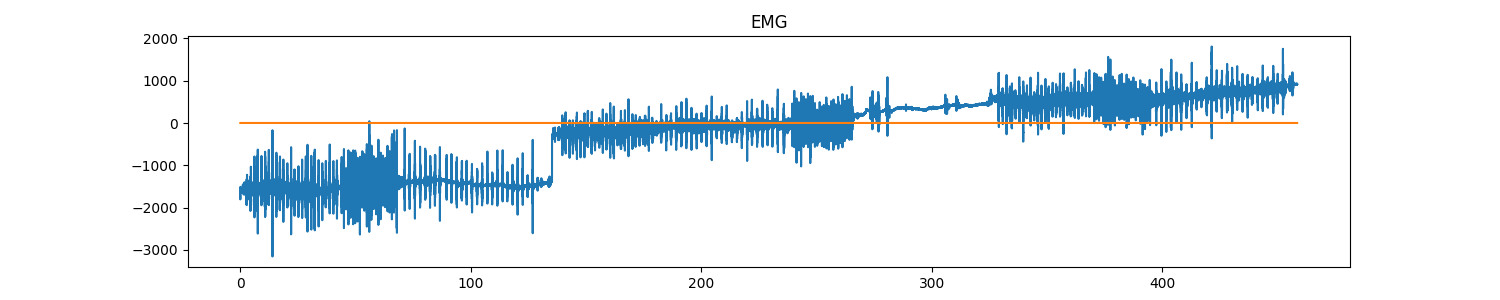

In [27]:
fig, axs = plt.subplots(1, figsize=(15, 3), sharex=True) # dont need status or lsl clock
# fig.suptitle('Data Flow')

plt.plot(data_timestamps_haptics, data_haptics[:, 0])
plt.plot(data_timestamps_haptics, data_haptics[:, 4])
plt.title('EMG')


Text(0.5, 1.0, 'EMG')

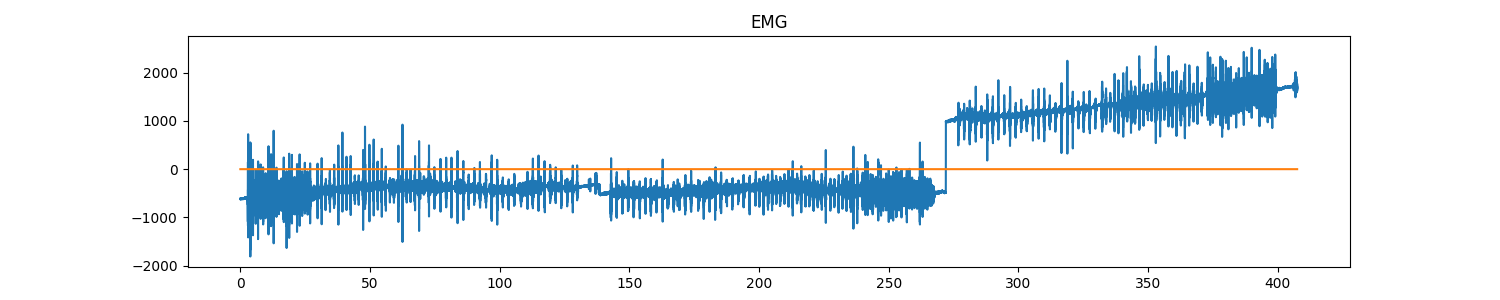

In [46]:
fig, axs = plt.subplots(1, figsize=(15, 3), sharex=True) # dont need status or lsl clock
# fig.suptitle('Data Flow')

plt.plot(data_timestamps_wo, data_wo[:, 0])
plt.plot(data_timestamps_wo, data_wo[:, 4])
plt.title('EMG')

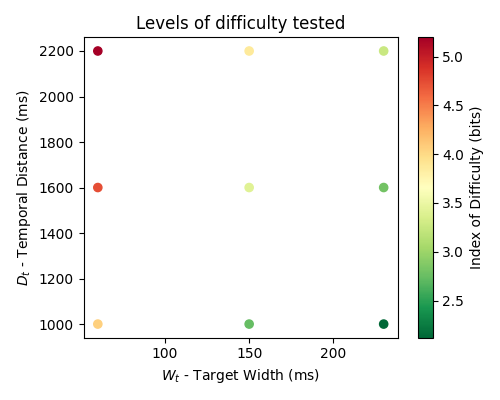

In [28]:
# Plot difficulty range
plt.figure(figsize=(5,4))
plt.scatter(gui_combos_haptics[:,0], gui_combos_haptics[:,1], c=ID_haptics, s=35)
plt.title('Levels of difficulty tested')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('$D_{t}$ - Temporal Distance (ms)')
plt.set_cmap('RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Index of Difficulty (bits)')
plt.tight_layout()
plt.show()

In [29]:
# fig,ax = plt.subplots(1, figsize=(5, 2))
# plt.scatter(ID, np.zeros(np.size(ID)), alpha=0.5)
# # Turn off tick labels
# ax.set_yticklabels([])
# ax.set_yticks([])
# plt.title("Index of Difficulty")
# plt.xlabel("Index of Difficulty")
# plt.show()


In [30]:
# print(data_timestamps)
# print(data_crossed)

In [47]:


process_haptics = data_processing.postProcessData(4000, data_haptics[:,0])
process_haptics.processAll(BP_LOW_CUTOFF, BP_HIGH_CUTOFF, LP_HIGH_CUTOFF, ORDER, FILTER_AFTER_N)

process_wo = data_processing.postProcessData(4000, data_wo[:,0])
process_wo.processAll(BP_LOW_CUTOFF, BP_HIGH_CUTOFF, LP_HIGH_CUTOFF, ORDER, FILTER_AFTER_N)


In [48]:

# def findThresholdCrossing(lpData, threshold):
#     threshold_crossings = np.diff(lpData > threshold, prepend=False)
#     positive_difference = np.diff(lpData, prepend=0) >= 0 
#     threshold_crossings_positive = np.argwhere(np.logical_and(threshold_crossings, positive_difference))[:,0]
#     return threshold_crossings_positive

# threshold_crossings_up_haptics = findThresholdCrossing(process_haptics.lpFilteredData, mvc_threshold)
# threshold_crossings_up_wo = findThresholdCrossing(process_wo.lpFilteredData, mvc_threshold)

# def thresholdCrossed(lpData, threshold):
#     threshold_crossings = np.diff(lpData > threshold)
#     print("function crossing", threshold_crossings)
#     positive_difference = np.diff(lpData) > 0    
#     print("funciton difference", positive_difference) 
#     thresholdCrossed =  np.any(np.logical_and(threshold_crossings, positive_difference))
#     return thresholdCrossed

# stop_cue = (np.where(np.diff(data_haptics[:, 4]) == 1)[0])
# start_cue = (np.where(np.diff(data_haptics[:, 4]) == -1)[0])

# if stop_cue[0] < start_cue[0]:
#     stop_cue = stop_cue[1:]

# print("threshold corssing:", threshold_crossings_up)
# print("start:", start_cue)
# print("stop:", stop_cue)

In [33]:
# # plt.figure()
# fig, axs = plt.subplots(2, figsize=(10, 5), sharex=True) # dont need status or lsl clock
# fig.suptitle('Data Flow')

# axs[0].plot(x_data, data_new[:, 0])
# axs[0].title.set_text('EMG')

# for xc in start_cue:
#     axs[1].axvline(x=xc/4000, color='g')
# for xc in stop_cue:
#     axs[1].axvline(x=xc/4000, color='r')

# axs[1].plot(x_data, process.lpFilteredData)
# axs[1].title.set_text('Filtered EMG')
# axs[1].axhline(y=mvc_threshold, color='darkmagenta')

# for ups in threshold_crossings_up:
#     axs[1].axvline(x=ups/4000, color='m')

# for xc in start_cue:
#     axs[1].axvline(x=xc/4000, color='g')
# for xc in stop_cue:
#     axs[1].axvline(x=xc/4000, color='r')

    
# axs[1].set_xlabel('Time (in seconds)')
# axs[1].set_ylabel('Amplitude (uV)')
# axs[0].set_ylabel('Amplitude (uV)')
# plt.setp(axs[0].get_xticklabels(), visible=False)
# plt.show()



In [50]:

stop_cue_timestamp_haptics = data_timestamps_haptics[np.where(np.diff(data_haptics[:, 4]) == 1)[0]]
# print(stop_cue_timestamp_haptics)

start_cue_timestamp_haptics = data_timestamps_haptics[np.where(np.diff(data_haptics[:, 4]) == -1)[0]]
# print(start_cue_timestamp_haptics)

data_crossed_small_haptics = data_crossed_haptics[data_crossed_haptics<np.max(data_timestamps_haptics)]
data_crossed_small_haptics = data_crossed_small_haptics[data_crossed_small_haptics>0]
# print(data_crossed_small_haptics)


stop_cue_timestamp_wo = data_timestamps_wo[np.where(np.diff(data_wo[:, 4]) == 1)[0]]
# print(stop_cue_timestampwo)

start_cue_timestamp_wo = data_timestamps_wo[np.where(np.diff(data_wo[:, 4]) == -1)[0]]
# print(start_cue_timestampwo)

data_crossed_small_wo = data_crossed_wo[data_crossed_wo<np.max(data_timestamps_wo)]
data_crossed_small_wo = data_crossed_small_wo[data_crossed_small_wo>0]
# print(data_crossed_small_wo)

In [35]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor=(1.04,1))

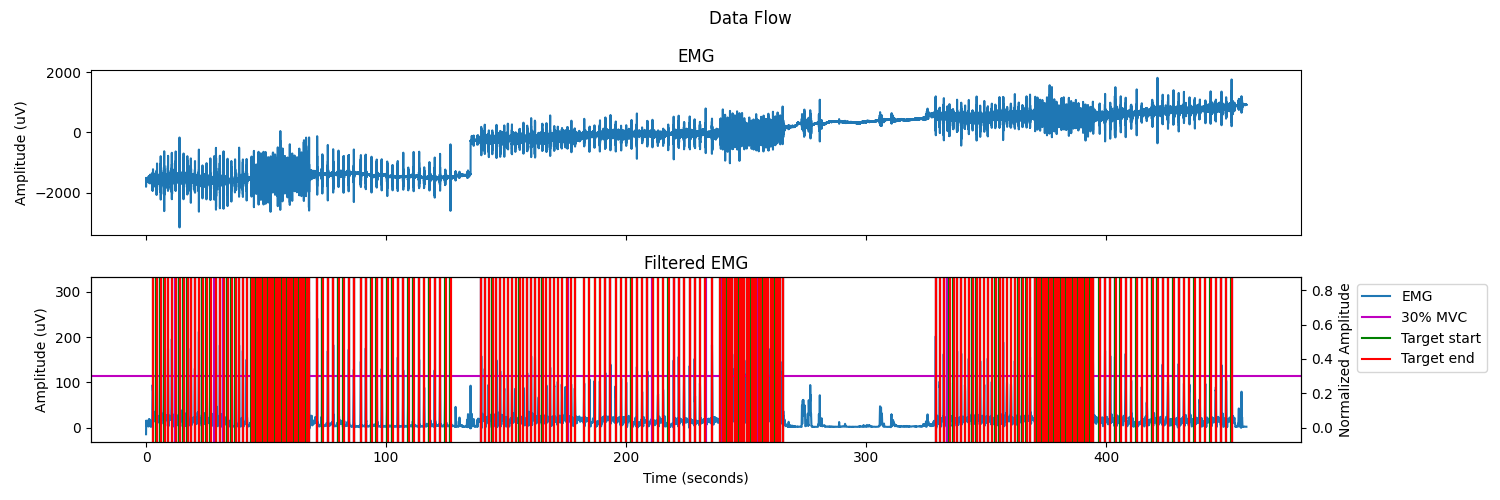

In [40]:
fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True) # dont need status or lsl clock
fig.suptitle('Haptics')

axs[0].plot(data_timestamps_haptics, data_haptics[:, 0])
axs[0].title.set_text('EMG')

for xc in start_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='g')
for xc in stop_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='r')

axs[1].plot(data_timestamps_haptics, process.lpFilteredData, label='EMG')
axs[1].title.set_text('Filtered EMG')
axs[1].axhline(y=mvc_threshold, color='m', label='30% MVC')

for ups in data_crossed_small_haptics:
    axs[1].axvline(x=ups, color='m')

for xc in start_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='g', label='Target start')
for xc in stop_cue_timestamp_haptics:
    axs[1].axvline(x=xc, color='r', label='Target end')

    
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Amplitude (uV)')
axs[0].set_ylabel('Amplitude (uV)')
ax1_twin = axs[1].twinx()
ax1_twin.set_ylabel('Normalized Amplitude')

# set twin scale (convert degree celsius to fahrenheit)
Norm_amp = lambda amp: amp/Mvc
# get left axis limits
ymin, ymax = axs[1].get_ylim()
# apply function and set transformed values to right axis limits
ax1_twin.set_ylim((Norm_amp(ymin),Norm_amp(ymax)))
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
ax1_twin.plot([],[])

# plt.legend(loc="upper right", ncol=2)
legend_without_duplicate_labels(axs[1])

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

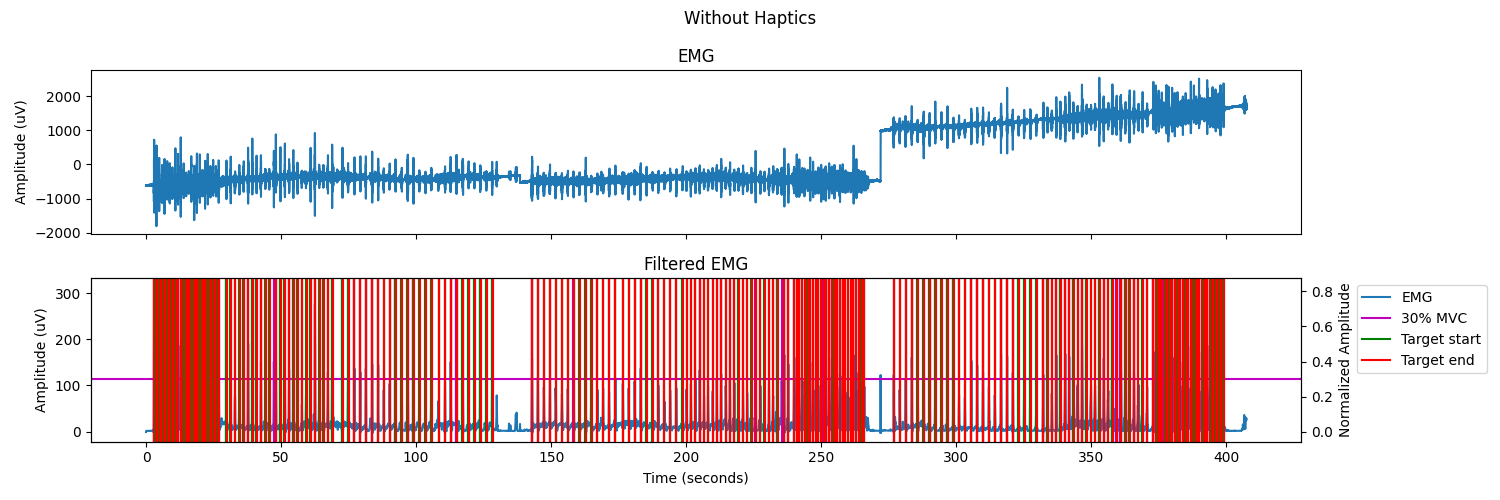

In [51]:
fig, axs = plt.subplots(2, figsize=(15, 5), sharex=True) # dont need status or lsl clock
fig.suptitle('Without Haptics')

axs[0].plot(data_timestamps_wo, data_wo[:, 0])
axs[0].title.set_text('EMG')

for xc in start_cue_timestamp_wo:
    axs[1].axvline(x=xc, color='g')
for xc in stop_cue_timestamp_wo:
    axs[1].axvline(x=xc, color='r')

axs[1].plot(data_timestamps_wo, process_wo.lpFilteredData, label='EMG')
axs[1].title.set_text('Filtered EMG')
axs[1].axhline(y=mvc_threshold, color='m', label='30% MVC')

for ups in data_crossed_small_wo:
    axs[1].axvline(x=ups, color='m')

for xc in start_cue_timestamp_wo:
    axs[1].axvline(x=xc, color='g', label='Target start')
for xc in stop_cue_timestamp_wo:
    axs[1].axvline(x=xc, color='r', label='Target end')

    
axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('Amplitude (uV)')
axs[0].set_ylabel('Amplitude (uV)')
ax1_twin = axs[1].twinx()
ax1_twin.set_ylabel('Normalized Amplitude')

# set twin scale (convert degree celsius to fahrenheit)
Norm_amp = lambda amp: amp/Mvc
# get left axis limits
ymin, ymax = axs[1].get_ylim()
# apply function and set transformed values to right axis limits
ax1_twin.set_ylim((Norm_amp(ymin),Norm_amp(ymax)))
# set an invisible artist to twin axes 
# to prevent falling back to initial values on rescale events
ax1_twin.plot([],[])

# plt.legend(loc="upper right", ncol=2)
legend_without_duplicate_labels(axs[1])

plt.setp(axs[0].get_xticklabels(), visible=False)
plt.tight_layout()
plt.show()

In [52]:
# print("start:", start_cue_timestamp_haptics)
# print("stop:",stop_cue_timestamp_haptics)
# print("corssed:",data_crossed_small_haptics)

In [70]:

start_cue_timestamp_haptics = start_cue_timestamp_haptics[np.logical_or(start_cue_timestamp_haptics<264, start_cue_timestamp_haptics>266)]
stop_cue_timestamp_haptics = stop_cue_timestamp_haptics[np.logical_or(stop_cue_timestamp_haptics<264, stop_cue_timestamp_haptics>266)]

start_cue_timestamp_haptics = start_cue_timestamp_haptics[start_cue_timestamp_haptics<450]
stop_cue_timestamp_haptics = stop_cue_timestamp_haptics[stop_cue_timestamp_haptics<450]

In [53]:
start_cue_timestamp_wo = start_cue_timestamp_wo[np.logical_or(start_cue_timestamp_wo<128, start_cue_timestamp_wo>129)]
stop_cue_timestamp_wo = stop_cue_timestamp_wo[np.logical_or(stop_cue_timestamp_wo<128, stop_cue_timestamp_wo>129)]

start_cue_timestamp_wo = start_cue_timestamp_wo[np.logical_or(start_cue_timestamp_wo<264, start_cue_timestamp_wo>267)]
stop_cue_timestamp_wo = stop_cue_timestamp_wo[np.logical_or(stop_cue_timestamp_wo<264, stop_cue_timestamp_wo>267)]

start_cue_timestamp_wo = start_cue_timestamp_wo[start_cue_timestamp_wo<397.5]
stop_cue_timestamp_wo = stop_cue_timestamp_wo[stop_cue_timestamp_wo<397.5]

In [59]:

threshold_closest_timestamp_wo = np.empty(np.size(start_cue_timestamp_wo[:]))
threshold_closest_timestamp_wo[:] = np.nan
correct_timestamp_wo = np.empty(np.size(start_cue_timestamp_wo[:]))
###for every value in the strt_cue 
for idx_cue, cue in enumerate(start_cue_timestamp_wo[:]):

    after_start_timestamp = start_cue_timestamp_wo[idx_cue] <= data_crossed_small_wo
    before_stop_timestamp = data_crossed_small_wo <= stop_cue_timestamp_wo[idx_cue]
    # check if there is a value between start_cue and stop cue
    if np.any(np.logical_and(after_start_timestamp, before_stop_timestamp)):
        in_target = np.argwhere(np.logical_and(after_start_timestamp, before_stop_timestamp))
        closet_value = in_target[0]
        threshold_closest_timestamp_wo[idx_cue] = data_crossed_small_wo[in_target[0]]
        correct_timestamp_wo[idx_cue] = True
    else:
        # if not - get closet 
        idx = (np.abs(data_crossed_small_wo - start_cue_timestamp_wo[idx_cue])).argmin()

        threshold_closest_timestamp_wo[idx_cue] = data_crossed_small_wo[idx]
        correct_timestamp_wo[idx_cue] = False
         # get rid of values greater than half the distance between the next cue 

# print("closest:", threshold_closest_timestamp)
# print("correctness:", correct_timestamp)

threshold_distance_timestamp_wo = threshold_closest_timestamp_wo - start_cue_timestamp_wo
# print("distance away:", threshold_distance_timestamp)


threshold_distance_timestamp_wo[threshold_distance_timestamp_wo > 0.5] = NaN
threshold_distance_timestamp_wo[threshold_distance_timestamp_wo < -0.5] = NaN
print("distance away:", threshold_distance_timestamp_wo)

threshold_distance_timestamp_wo_nan = threshold_distance_timestamp_wo[~np.isnan(threshold_distance_timestamp_wo)]

distance away: [ 0.1470386  0.00825    0.058554   0.1146483  0.018      0.02675
 -0.0384407 -0.0411121  0.026      0.0351006  0.0541656  0.1358211
  0.0862734        nan -0.0565039  0.00475    0.0145     0.09571
  0.0935     0.046      0.07825    0.0335     0.07275    0.0822437
  0.118526   0.104601   0.04625          nan        nan  0.071
  0.0528421  0.04325    0.04425    0.0636773        nan        nan
 -0.052277   0.0870292  0.0984855  0.085572   0.0574113  0.00275
        nan        nan  0.02375    0.00925          nan -0.009
        nan  0.032      0.1055601  0.0300273  0.1648082  0.1727256
  0.007      0.1551939  0.1608286        nan  0.058     -0.00025
        nan  0.0921121  0.05325          nan        nan        nan
        nan        nan  0.003     -0.019      0.0809121  0.0699001
        nan -0.02275          nan -0.00325    0.01075          nan
  0.0520348        nan        nan        nan -0.013            nan
  0.1146547        nan        nan        nan        nan  0.08
 

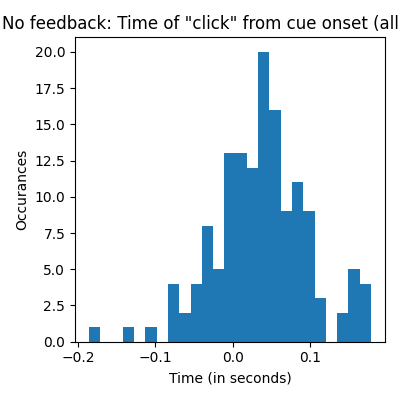

In [56]:
plt.figure(figsize=(4,4))
plt.hist(threshold_distance_timestamp_wo, bins=25)
plt.title('No feedback: Time of "click" from cue onset (all levels)')
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurances')
plt.tight_layout()
plt.show()

In [60]:
rt_normalized = (threshold_distance_timestamp_wo_nan - np.mean(threshold_distance_timestamp_wo_nan))/np.std(threshold_distance_timestamp_wo_nan)
stats.kstest(rt_normalized, stats.norm.cdf)
# if p val is greater than 0.05 -> GAUSSIAN

KstestResult(statistic=0.05156847015610447, pvalue=0.8223582900324465)

C:\Users\Nikole Chetty\AppData\Local\Temp\ipykernel_20868\1673751320.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 4))


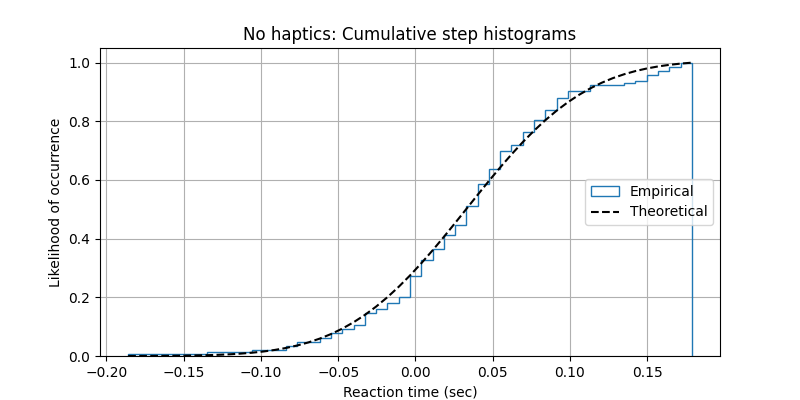

In [71]:
np.random.seed(0)

mu = np.mean(threshold_distance_timestamp_wo_nan)
sigma = np.std(threshold_distance_timestamp_wo_nan)
n_bins = 50

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(threshold_distance_timestamp_wo_nan, n_bins, density=1, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = stats.norm.pdf(bins, mu, sigma).cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')


ax.grid(True)
ax.legend(loc='right')
ax.set_title('No haptics: Cumulative step histograms')
ax.set_xlabel('Reaction time (sec)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [72]:
# Exclude the first pulse - that is ardunio power cycling
# start_cue_timestamp = start_cue_timestamp[1:] # [1:]
# stop_cue_timestamp = stop_cue_timestamp[1:] #[1:]

threshold_closest_timestamp_haptics = np.empty(np.size(start_cue_timestamp_haptics[:]))
threshold_closest_timestamp_haptics[:] = np.nan
correct_timestamp_haptics = np.empty(np.size(start_cue_timestamp_haptics[:]))
###for every value in the strt_cue 
for idx_cue, cue in enumerate(start_cue_timestamp_haptics[:]):

    after_start_timestamp = start_cue_timestamp_haptics[idx_cue] <= data_crossed_small_haptics
    before_stop_timestamp = data_crossed_small_haptics <= stop_cue_timestamp_haptics[idx_cue]
    # check if there is a value between start_cue and stop cue
    if np.any(np.logical_and(after_start_timestamp, before_stop_timestamp)):
        in_target = np.argwhere(np.logical_and(after_start_timestamp, before_stop_timestamp))
        closet_value = in_target[0]
        threshold_closest_timestamp_haptics[idx_cue] = data_crossed_small_haptics[in_target[0]]
        correct_timestamp_haptics[idx_cue] = True
    else:
        # if not - get closet 
        idx = (np.abs(data_crossed_small_haptics - start_cue_timestamp_haptics[idx_cue])).argmin()

        threshold_closest_timestamp_haptics[idx_cue] = data_crossed_small_haptics[idx]
        correct_timestamp_haptics[idx_cue] = False
         # get rid of values greater than half the distance between the next cue 

# print("closest:", threshold_closest_timestamp)
# print("correctness:", correct_timestamp)

threshold_distance_timestamp_haptics = threshold_closest_timestamp_haptics - start_cue_timestamp_haptics
# print("distance away:", threshold_distance_timestamp)


threshold_distance_timestamp_haptics[threshold_distance_timestamp_haptics > 0.5] = NaN
threshold_distance_timestamp_haptics[threshold_distance_timestamp_haptics < -0.5] = NaN
print("distance away:", threshold_distance_timestamp_haptics)

threshold_distance_timestamp_haptics_nan = threshold_distance_timestamp_haptics[~np.isnan(threshold_distance_timestamp_haptics)]

distance away: [       nan  0.2504617  0.05425   -0.07725   -0.0195884  0.005
 -0.0055    -0.03775    0.0362595  0.00575   -0.1145961  0.00725
  0.0560143 -0.0056825  0.05775    0.0695254 -0.0599229  0.01575
 -0.0860451  0.0140867  0.032     -0.01275    0.01325    0.012
 -0.044      0.0917753  0.0842507  0.0555     0.0145     0.07075
  0.0815    -0.0241548  0.011      0.0243957  0.13575   -0.07325
  0.00925    0.0535    -0.034     -0.03975    0.0622128  0.018
  0.03475    0.0675     0.031      0.0074474 -0.1050474 -0.0875782
 -0.2191355 -0.003      0.035      0.0045     0.0553486  0.1138479
  0.1325644  0.08275   -0.01575   -0.02825    0.0695475 -0.02825
  0.0625     0.0780351 -0.0389168  0.0310055  0.0905185  0.0505415
  0.1721581        nan  0.0411323  0.1349012        nan  0.078
  0.0452906  0.0666662        nan -0.00525    0.06075   -0.035
        nan -0.0890575 -0.00175    0.012            nan -0.0330704
  0.0938166        nan  0.1478597        nan  0.0455     0.04325
  0.0493845 

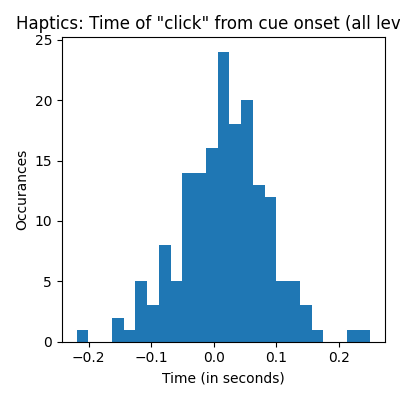

In [73]:
plt.figure(figsize=(4,4))
plt.hist(threshold_distance_timestamp_haptics, bins=25)
plt.title('Haptics: Time of "click" from cue onset (all levels)')
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurances')
plt.tight_layout()
plt.show()

In [74]:
rt_normalized = (threshold_distance_timestamp_haptics_nan - np.mean(threshold_distance_timestamp_haptics_nan))/np.std(threshold_distance_timestamp_haptics_nan)
stats.kstest(rt_normalized, stats.norm.cdf)
# if p val is greater than 0.05 -> GAUSSIAN

KstestResult(statistic=0.045593274704108955, pvalue=0.8506808538233477)

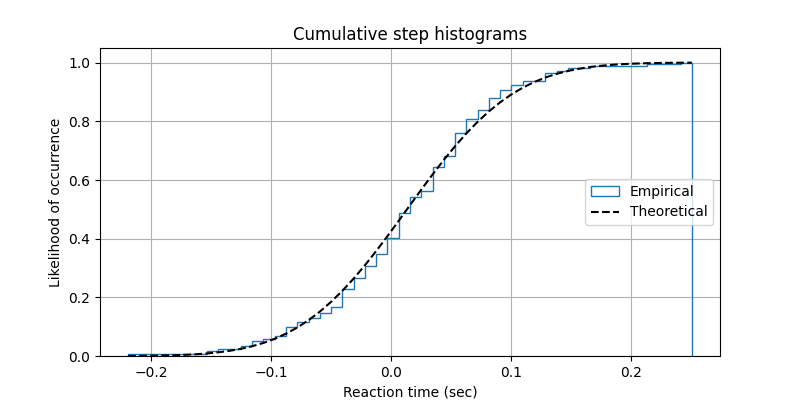

In [75]:

np.random.seed(0)

mu = np.mean(threshold_distance_timestamp_haptics_nan)
sigma = np.std(threshold_distance_timestamp_haptics_nan)
n_bins = 50

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(threshold_distance_timestamp_haptics_nan, n_bins, density=1, histtype='step',
                           cumulative=True, label='Empirical')

# Add a line showing the expected distribution.
y = stats.norm.pdf(bins, mu, sigma).cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')


ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('Reaction time (sec)')
ax.set_ylabel('Likelihood of occurrence')

plt.show()

In [88]:
np.histogram(np.hstack((threshold_distance_timestamp_haptics_nan, threshold_distance_timestamp_wo_nan)), bins=25)

(array([ 1,  1,  0,  2,  2,  5,  4, 12,  8, 21, 23, 31, 41, 38, 42, 25, 26,
        11,  6,  7,  6,  1,  0,  1,  1], dtype=int64),
 array([-0.2191355 , -0.20035161, -0.18156772, -0.16278384, -0.14399995,
        -0.12521606, -0.10643217, -0.08764828, -0.0688644 , -0.05008051,
        -0.03129662, -0.01251273,  0.00627116,  0.02505504,  0.04383893,
         0.06262282,  0.08140671,  0.1001906 ,  0.11897448,  0.13775837,
         0.15654226,  0.17532615,  0.19411004,  0.21289392,  0.23167781,
         0.2504617 ]))

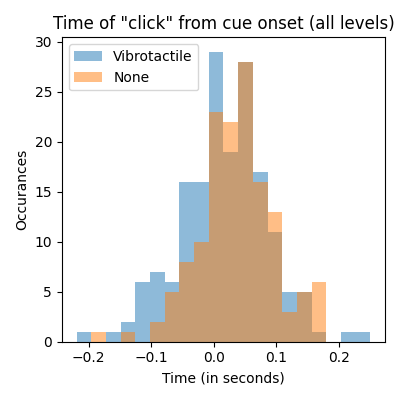

In [92]:

bins = np.histogram(np.hstack((threshold_distance_timestamp_haptics_nan, threshold_distance_timestamp_wo_nan)), bins=20)[1]

plt.figure(figsize=(4,4))
plt.hist(threshold_distance_timestamp_haptics, bins=bins, alpha=0.5, label='Vibrotactile')
plt.hist(threshold_distance_timestamp_wo, bins=bins, alpha=0.5, label='None')
plt.title('Time of "click" from cue onset (all levels)')
plt.xlabel('Time (in seconds)')
plt.ylabel('Occurances')
plt.legend()
plt.tight_layout()

plt.show()

In [76]:
repitions = gui_reps_haptics
print("repitions:", repitions)
correct_timestamp_haptics = correct_timestamp_haptics[:-1]
level = np.arange(len(correct_timestamp_haptics))//repitions
print('Levels:', level)




performance_haptics = np.bincount(level,correct_timestamp_haptics)/np.bincount(level)
print('performance per level:', performance_haptics)

repitions: 25
Levels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]
performance per level: [0.52       0.68       0.72       0.16       0.24       0.48
 0.4        0.36       0.45833333]


In [77]:

repitions = gui_reps_wo
print("repitions:", repitions)
correct_timestamp_wo = correct_timestamp_wo[:-1]
level = np.arange(len(correct_timestamp_wo))//repitions
print('Levels:', level)




performance_wo = np.bincount(level,correct_timestamp_wo)/np.bincount(level)
print('performance per level:', performance_wo)



repitions: 25
Levels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8]
performance per level: [0.84       0.6        0.52       0.16       0.08       0.24
 0.44       0.56       0.56521739]


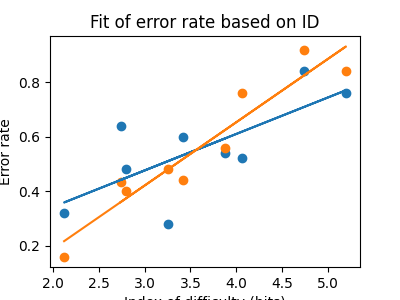

In [96]:
coef = np.polyfit(ID_haptics,1-performance_haptics,1)
ID_fit_haptics = np.poly1d(coef) 

coef = np.polyfit(ID_wo,1-performance_wo,1)
ID_fit_wo = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.figure(figsize=(4,3))
plt.scatter(ID_haptics, 1-performance_haptics, label='Vibrotactile')
plt.scatter(ID_wo, 1-performance_wo, label='None')
plt.plot(ID_haptics, ID_fit_haptics(ID_haptics)) #'--k'=black dashed line, 'yo' = yellow circle marker
plt.plot(ID_wo, ID_fit_wo(ID_wo)) #'--k'=black dashed line, 'yo' = yellow circle marker
plt.title('Fit of error rate based on ID')
plt.xlabel('Index of difficulty (bits)')
plt.ylabel('Error rate')
plt.show()
plt.legend()
# plt.xlim([0, 4])
plt.ylim([0, 1.05])
plt.tight_layout()

[-0.00202291  0.85021249]


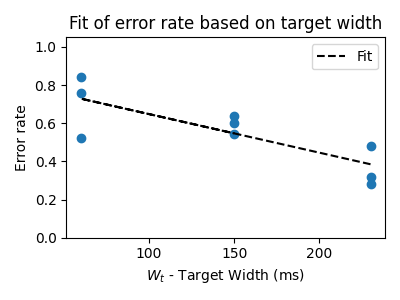

In [ ]:
wt_coef = np.polyfit(gui_combos_haptics[:,0],1-performance_haptics,1)
print(wt_coef)
wt_fn = np.poly1d(wt_coef) 

plt.figure(figsize=(4,3))
plt.scatter(gui_combos_haptics[:,0], 1-performance_haptics[0:np.shape(ID)[0]])
plt.plot(gui_combos_haptics[:, 0][0:-1:3], wt_fn(gui_combos_haptics[:, 0][0:-1:3]), label="Fit")
plt.title('Fit of error rate based on target width')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.legend()
plt.tight_layout()
plt.show()


[-0.00292513  0.98399519]


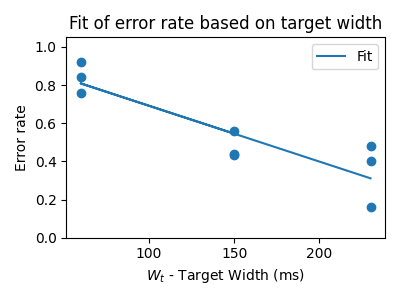

In [93]:
wt_coef = np.polyfit(gui_combos_wo[:,0],1-performance_wo,1)
print(wt_coef)
wt_wo = np.poly1d(wt_coef) 

plt.figure(figsize=(4,3))
plt.scatter(gui_combos_wo[:,0], 1-performance_wo[0:np.shape(ID_wo)[0]])
plt.plot(gui_combos_wo[:, 0][0:-1:3], wt_wo(gui_combos_wo[:, 0][0:-1:3]), label="Fit")
plt.title('Fit of error rate based on target width')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.legend()
plt.tight_layout()
plt.show()


[-0.00292513  0.98399519]
[-0.00202291  0.85021249]


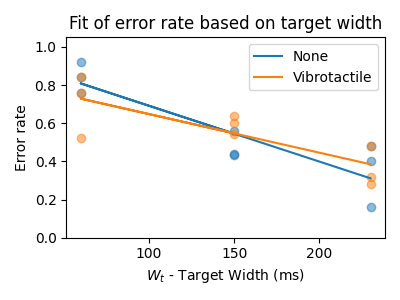

In [95]:
wt_coef_wo = np.polyfit(gui_combos_wo[:,0],1-performance_wo,1)
print(wt_coef_wo)
wt_wo = np.poly1d(wt_coef_wo) 

wt_coef_haptics = np.polyfit(gui_combos_haptics[:,0],1-performance_haptics,1)
print(wt_coef_haptics)
wt_haptics = np.poly1d(wt_coef_haptics) 

plt.figure(figsize=(4,3))
plt.scatter(gui_combos_wo[:,0], 1-performance_wo[0:np.shape(ID_wo)[0]], alpha=0.5)
plt.plot(gui_combos_wo[:, 0][0:-1:3], wt_wo(gui_combos_wo[:, 0][0:-1:3]), label="None")

plt.scatter(gui_combos_haptics[:,0], 1-performance_haptics[0:np.shape(ID_haptics)[0]], alpha=0.5)
plt.plot(gui_combos_haptics[:, 0][0:-1:3], wt_haptics(gui_combos_haptics[:, 0][0:-1:3]), label="Vibrotactile")
plt.title('Fit of error rate based on target width')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
gui_combos_haptics[:, 1][0:3]

array([1600, 1000, 2200])

[2.82407407e-05 5.08333333e-01]
[1.45893720e-04 3.21545894e-01]


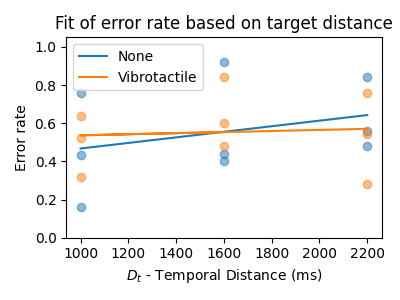

In [101]:

dt_coef_haptics = np.polyfit(gui_combos_haptics[:,1],1-performance_haptics,1)
print(dt_coef_haptics)
dt_fn_haptics = np.poly1d(dt_coef_haptics) 

dt_coef_wo = np.polyfit(gui_combos_wo[:,1],1-performance_wo,1)
print(dt_coef_wo)
dt_fn_wo = np.poly1d(dt_coef_wo) 

plt.figure(figsize=(4,3))

plt.scatter(gui_combos_wo[:,1], 1-performance_wo[0:np.shape(ID_wo)[0]], alpha=0.5)
plt.plot(gui_combos_wo[:, 1][0:3], dt_fn_wo(gui_combos_wo[:, 1][0:3]),  label="None")


plt.scatter(gui_combos_haptics[:,1], 1-performance_haptics[0:np.shape(ID_haptics)[0]], alpha=0.5)
plt.plot(gui_combos_haptics[:, 1][0:3], dt_fn_haptics(gui_combos_haptics[:, 1][0:3]), label="Vibrotactile")
plt.title('Fit of error rate based on target distance')
plt.xlabel('$D_{t}$ - Temporal Distance (ms)')
plt.ylabel('Error rate')
plt.ylim([0, 1.05])
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
widths = gui_combos_haptics[:,0]//60
# print(widths)
width_levels = np.repeat(widths, repitions)
# print(width_levels)

# box_plot_data_width = np.split(threshold_distance_timestamp, np.unique(width_levels, return_index=True)[1][1:])
# # print(box_plot_data_width)

width_split = [threshold_distance_timestamp_haptics[width_levels == i] for i in range(width_levels.max() + 1)]
width_split = width_split[1:]
# print(width_split)
# print(np.shape(width_split))

# width_split = width_split[~np.isnan(width_split)]
width_no_nan  = [list[~np.isnan(list)] for list in width_split]
print(width_no_nan)


[array([-0.00525  ,  0.06075  , -0.035    , -0.0890575, -0.00175  ,
        0.012    , -0.0330704,  0.0938166,  0.1478597,  0.0455   ,
        0.04325  ,  0.0493845, -0.0376763, -0.0075   ,  0.1036061,
        0.1086301,  0.0415   ,  0.007    ,  0.02225  ,  0.016    ,
       -0.05325  ,  0.01     , -0.1485961, -0.04575  ,  0.0185   ,
       -0.0903166,  0.09775  , -0.1130348,  0.1326151,  0.012    ,
       -0.04329  ,  0.001    , -0.01675  ,  0.06575  ,  0.0115   ,
       -0.0443358,  0.03575  ,  0.0601665, -0.01875  ,  0.0025   ,
        0.062257 ,  0.04075  , -0.1521629, -0.0335502, -0.0822609,
       -0.0045   ,  0.01875  ,  0.0155   ,  0.04075  ,  0.0910849,
       -0.0853065, -0.1212513]), array([-0.1194089, -0.1365696,  0.088484 , -0.06475  , -0.032    ,
        0.0555216,  0.05875  ,  0.025    ,  0.00175  , -0.00975  ,
        0.0427087,  0.0563197,  0.04125  ,  0.1166333,  0.037492 ,
       -0.02275  ,  0.04225  , -0.01025  ,  0.0725244,  0.0381595,
        0.0705175,  0.063313

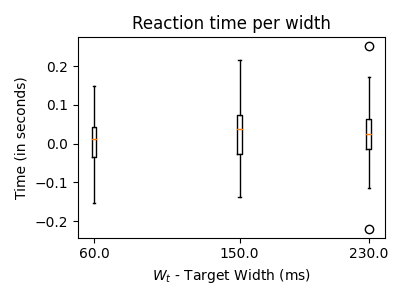

In [ ]:

fig1, ax1 = plt.subplots(figsize=(4,3))
ax1.set_title('')
ax1.boxplot(width_no_nan, positions=np.unique(gui_combos_haptics[:,0]), widths=3)
plt.title('Reaction time per width')
plt.ylabel('Time (in seconds)')
plt.xlabel('$W_{t}$ - Target Width (ms)')
plt.xlim([50, 240])
plt.tight_layout()
from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

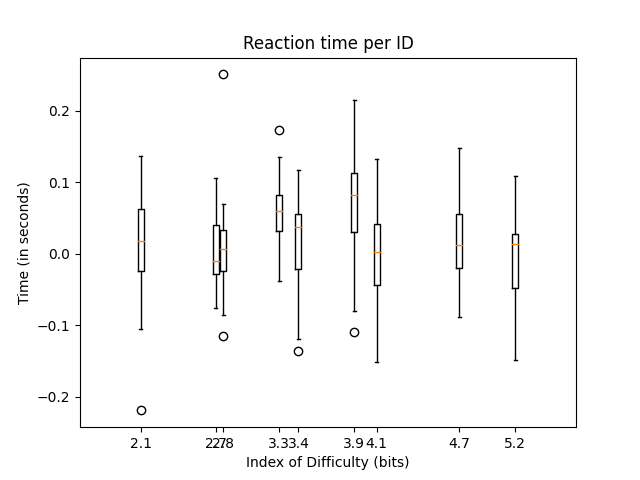

In [ ]:
box_plot_data = np.split(threshold_distance_timestamp, np.unique(level, return_index=True)[1][1:])
# print(box_plot_data)
box_plot_data_no_nan  = [list[~np.isnan(list)] for list in box_plot_data]

fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(box_plot_data_no_nan, positions=ID.round(3), widths=0.05)
plt.title('Reaction time per ID')
plt.ylabel('Time (in seconds)')
plt.xlabel('Index of Difficulty (bits)')
from matplotlib.ticker import FormatStrFormatter
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [ ]:
# # Exclude the first pulse - that is ardunio power cycling
# start_cue = start_cue[1:] # [1:]
# stop_cue = stop_cue[1:] #[1:]

# threshold_closest = np.empty(np.size(start_cue[:]))
# threshold_closest[:] = np.nan
# correct = np.empty(np.size(start_cue[:]))
# ###for every value in the strt_cue 
# for idx_cue, cue in enumerate(start_cue[:]):

#     after_start = start_cue[idx_cue] <= threshold_crossings_up
#     before_stop = threshold_crossings_up <= stop_cue[idx_cue]
#     # check if there is a value between start_cue and stop cue
#     if np.any(np.logical_and(after_start, before_stop)):
#         in_target = np.argwhere(np.logical_and(after_start, before_stop))
#         closet_value = in_target[0]
#         threshold_closest[idx_cue] = threshold_crossings_up[in_target[0]]
#         correct[idx_cue] = True
#     else:
#         # if not - get closet 
#         idx = (np.abs(threshold_crossings_up - start_cue[idx_cue])).argmin()

#         threshold_closest[idx_cue] = threshold_crossings_up[idx]
#         correct[idx_cue] = False
#          # get rid of values greater than half the distance between the next cue 

# print("closest:", threshold_closest)
# print("correctness:", correct)

# threshold_distance = threshold_closest - start_cue
# print("distance away:", threshold_distance)


# threshold_distance[threshold_distance > 4000] = NaN
# threshold_distance[threshold_distance < -4000] = NaN
# print("distance away:", threshold_distance)

In [ ]:
# plt.figure()
# plt.hist(threshold_distance/4000, bins=15)
# plt.title('Time of "click" from cue onset (all levels)')
# plt.xlabel('Time (in seconds)')
# plt.ylabel('Occurances')
# plt.show()

In [ ]:
# rt = threshold_distance/4000
# print(rt)
# rt = rt[~np.isnan(rt)]
# print(rt)

In [ ]:
# rt_normalized = (rt - np.mean(rt))/np.std(rt)
# stats.kstest(rt_normalized, stats.norm.cdf)
# # if p val is greater than 0.05 -> GAUSSIAN

In [ ]:


# np.random.seed(0)

# mu = np.mean(rt)
# sigma = np.std(rt)
# n_bins = 50

# fig, ax = plt.subplots(figsize=(8, 4))

# # plot the cumulative histogram
# n, bins, patches = ax.hist(rt, n_bins, density=1, histtype='step',
#                            cumulative=True, label='Empirical')

# # Add a line showing the expected distribution.
# y = stats.norm.pdf(bins, mu, sigma).cumsum()
# y /= y[-1]

# ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')



# # tidy up the figure
# ax.grid(True)
# ax.legend(loc='right')
# ax.set_title('Cumulative step histograms')
# ax.set_xlabel('Reaction time (sec)')
# ax.set_ylabel('Likelihood of occurrence')

# plt.show()

In [ ]:
# repitions = gui_data['reps'] 
# print("repitions:", repitions)
# level = np.arange(len(correct))//repitions
# print('Levels:', level)
# performance = np.bincount(level,correct)/np.bincount(level)
# print('performance per level:', performance)


In [ ]:


# box_plot_data = np.split(threshold_distance/4000, np.unique(level, return_index=True)[1][1:])
# print(box_plot_data)

In [ ]:
# for idx, data in enumerate(box_plot_data):
#     box_plot_data[idx] = data[~np.isnan(data)]



In [ ]:
# fig1, ax1 = plt.subplots()
# ax1.set_title('Basic Plot')
# ax1.boxplot(box_plot_data[0:np.shape(ID)[0]], positions=ID.round(3), widths=0.05)
# plt.title('Reaction time per ID')
# plt.ylabel('Time (in seconds)')
# plt.xlabel('Index of Difficulty (bits)')
# from matplotlib.ticker import FormatStrFormatter
# ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [ ]:
# plt.figure(figsize=(5,3))
# plt.scatter(ID, 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on ID')
# plt.xlabel('Index of difficulty (bits)')
# plt.ylabel('Error rate')
# plt.show()
# # plt.xlim([0, 4])
# plt.ylim([0, 1.05])
# plt.tight_layout()

In [ ]:
# plt.figure(figsize=(5,3))
# plt.scatter(gui_data['combos'][:,0], 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on target width')
# plt.xlabel('$W_{t}$ - Target Width (ms)')
# plt.ylabel('Error rate')
# plt.ylim([0, 1.05])
# plt.tight_layout()
# plt.show()


In [ ]:
# plt.figure(figsize=(5,3))
# plt.scatter(gui_data['combos'][:,1], 1-performance[0:np.shape(ID)[0]])
# plt.title('Fit of error rate based on target distance')
# plt.xlabel('$D_{t}$ - Temporal Distance (ms)')
# plt.ylabel('Error rate')
# plt.ylim([0, 1.05])
# plt.tight_layout()
# plt.show()